In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split, cross_val_score


#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [3]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [4]:
df = pd.read_csv('final_merge.csv')

In [5]:
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      3095 non-null   object 
 1   state                       3095 non-null   object 
 2   ruca                        3084 non-null   float64
 3   brfss_access2_ageadjprv     3095 non-null   float64
 4   brfss_checkup_ageadjprv     3095 non-null   float64
 5   brfss_csmoking_ageadjprv    3095 non-null   float64
 6   brfss_depression_ageadjprv  3095 non-null   float64
 7   brfss_diabetes_ageadjprv    3095 non-null   float64
 8   brfss_ghlth_ageadjprv       3095 non-null   float64
 9   brfss_mhlth_ageadjprv       3095 non-null   float64
 10  brfss_obesity_ageadjprv     3095 non-null   float64
 11  brfss_access2_ageadjprv.1   3095 non-null   float64
 12  brfss_checkup_ageadjprv.1   3095 non-null   float64
 13  brfss_csmoking_ageadjprv.1  3095 

# Linear Regression Assumptions Check
## Linearity
Linearity between the dependent variable and the independent variables **PASS**

    * The relationship between the dependent variable and the independent variables is linear. See EDA for more details.
## Independence
No auto-correlation in the data (i.e. the data is not time-series data) **PASS** 

    * DW = 1.34
## No Multicollinearity
No or little multicollinearity between the independent variables **PASS** 

    * All features selected have a VIF < 5 
## Normality of Residuals
The residuals are normally distributed **PASS** 
    * QQ Plot: The residuals are normally distrubuted except for the tails. Not a severe violation. But worth noting.
    
## Homoscedasticity
Homoscedasticity  **PASS**
    * Residuals vs Fitted Plot: no clear pattern in the residuals vs fitted plot.

In [7]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]
covariates = [
    "brfss_access2_ageadjprv", # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
    "brfss_checkup_ageadjprv", # percentage of adults aged >=18 years who had a checkup in the past 12 months
    #"brfss_csmoking_ageadjprv", # percentage of adults aged >=18 years who are current smokers
    "brfss_mhlth_ageadjprv", # percentage of adults aged >=18 years who report 14 or more days of poor mental health in the past 30 days
    "brfss_obesity_ageadjprv", # percentage of adults aged >=18 years who have obesity
    "pct_ed_lt9", # percentage of adults aged >=25 years with less than a 9th grade education
    "pct_ed_9_12", # percentage of adults aged >=25 years with a 9th to 12th grade education and no diploma
    "pct_ed_hs", # percentage of adults aged >=25 years with a high school diploma or GED
    #"pct_ed_sc", # percentage of adults aged >=25 years with some college (1-4 years)
    "pct_ed_asc", # percentage of adults aged >=25 years with an associate's degree
    #"pct_ed_b", # percentage of adults aged >=25 years with a bachelor's degree
    # "pct_ed_gr", # percentage of adults aged >=25 years with a graduate or professional degree
    "pct_age_gte65", # percentage of adults aged >=65 years
    "pct_occ_unemp", #  percentage of employed adults aged >=16 years who are unemployed
    # "pct_occ_mgt", # percentage of employed adults aged >=16 years who work in management, business, science, and arts occupations
    #"pct_occ_svc", # percentage of employed adults aged >=16 years who work in service occupations
    #"pct_occ_sales", # percentage of employed adults aged >=16 years who work in sales and office occupations
    # "pct_occ_nat_res", # percentage of employed adults aged >=16 years who work in natural resources, construction, and maintenance occupations
    # "pct_occ_prod", # percentage of employed adults aged >=16 years who work in production, transportation, and material moving occupations
    "pct_ses_pov",  # percentage of all people in poverty
    "pct_tp_veh_0", # percentage of households with zero vehicles
    # "pct_tp_veh_1", # percentage of households with one vehicle
    # "pct_tp_veh_2", # percentage of households with two vehicles
    # "pct_tp_veh_3" # percentage of households with three or more vehicles
    "ruca", # rural-urban continuum codes
    "bb_int_struct" # broadband internet access availability 
]

# variables commented out due to high VIF values (>= 5)

X = df[iv + covariates]
y = df[dv]

features = "+".join(iv + covariates)
y, X = dmatrices(dv[0] + ' ~' + features, data=df, return_type='dataframe')

# Linear Regression and Assumptions Check

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.904    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                6517.2227
Date:               2023-11-24 07:43         BIC:                6613.7664
No. Observations:   3084                     Log-Likelihood:     -3242.6  
Df Model:           15                       F-statistic:        1944.    
Df Residuals:       3068                     Prob (F-statistic): 0.00     
R-squared:          0.905                    Scale:              0.48200  
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   1.2782   0.4792  2.6672 0.0077  0.3386  2.2178
pct_dg_bb_int              -0.0259   0.0026 -9.9583 0.0000 -0.0310 -0.0208
brfss_access2_ageadjprv     0.1092   0.0034 32.

,VIF,Tolerance,features
0,1469.430,0.000,Intercept
1,2.690,0.370,pct_dg_bb_int
2,2.370,0.420,brfss_access2_ageadjprv
3,1.640,0.610,brfss_checkup_ageadjprv
4,3.280,0.310,brfss_mhlth_ageadjprv
5,2.530,0.400,brfss_obesity_ageadjprv
6,2.060,0.480,pct_ed_lt9
7,2.960,0.340,pct_ed_9_12
8,2.310,0.430,pct_ed_hs
9,1.510,0.660,pct_ed_asc


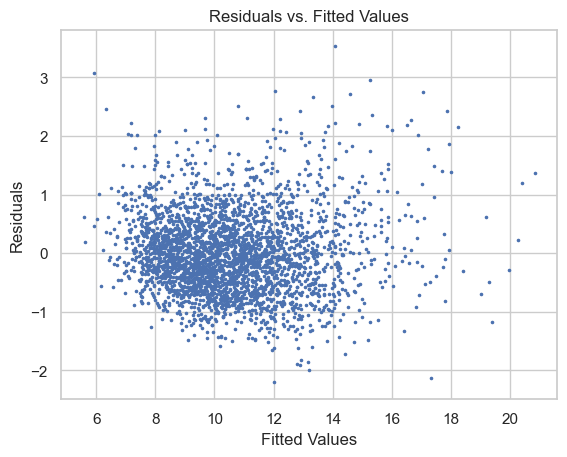

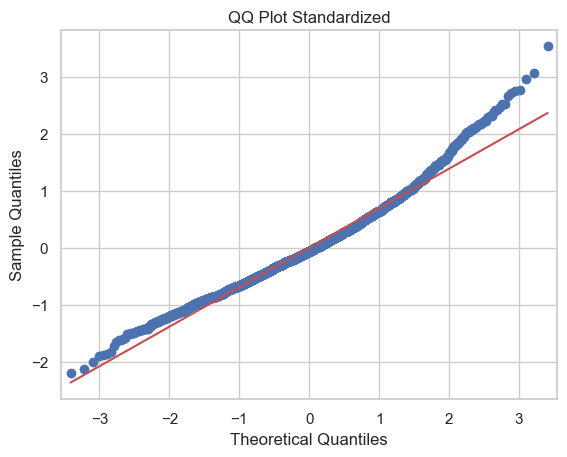

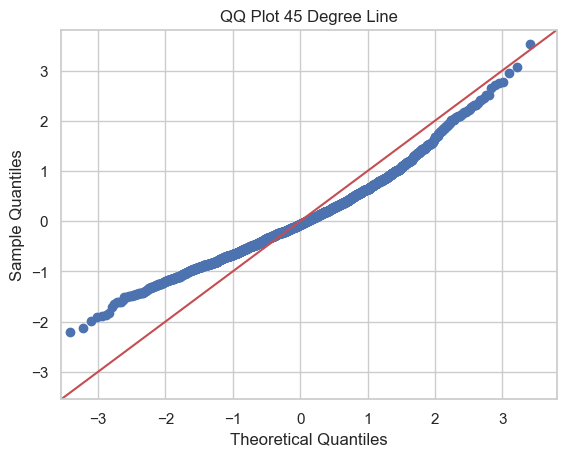

In [8]:
model = smf.ols(formula=dv[0] + ' ~' + features, data=df)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

pct_dg_bb_int (Broadband Internet access): The negative coefficient indicates that as broadband internet access increases, the age-adjusted diabetes prevalence decreases, holding all other factors constant.

Health-related variables (like brfss_access2_ageadjprv, brfss_checkup_ageadjprv, brfss_mhlth_ageadjprv, brfss_obesity_ageadjprv): Positive coefficients for these variables suggest that higher values in these health-related variables are associated with higher diabetes prevalence.

Educational variables (pct_ed_lt9, pct_ed_9_12, pct_ed_hs, pct_ed_asc): Varying signs on these coefficients indicate differing impacts of education levels on diabetes prevalence. For instance, having more of the population with less than a 9th-grade education (pct_ed_lt9) is associated with higher diabetes prevalence, while higher high school graduation rates (pct_ed_hs) are associated with lower prevalence.

pct_age_gte65 (Percentage of the population that is 65 or older): The negative coefficient suggests that areas with a higher percentage of older adults tend to have a lower diabetes prevalence when controlling for other factors.

pct_occ_unemp (Percentage of unemployed): The positive coefficient here indicates that higher unemployment is associated with higher diabetes prevalence.

pct_ses_pov (Percentage below poverty level): The positive coefficient indicates that higher poverty levels are associated with higher diabetes prevalence.

pct_tp_veh_0 (Percentage with no vehicle available): The positive coefficient suggests that having no vehicle available is associated with higher diabetes prevalence.

In [9]:
#create model fit measures table
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['n'] = [results.nobs]
fit_measures['k'] = [results.df_model]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

#create table forf Omnibus ANOVA test
omnibus = pd.DataFrame()
omnibus['Chi^2'] = [results.ess]
omnibus['df'] = [results.df_model]
omnibus['Prob > Chi^2'] = [results.f_pvalue]
display(omnibus.round(2))

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,n,k,df_resid,df_model
0,0.530,0.690,0.900,0.900,1943.510,0.000,6517.220,6613.770,-3242.610,3084.000,15.000,3068.000,15.000


,Chi^2,df,Prob > Chi^2
0,14051.560,15.000,0.000


                     Results: Robust linear model
Model:                 RLM                       Df Residuals:  3068   
Dependent Variable:    brfss_diabetes_ageadjprv  Norm:          HuberT 
Date:                  2023-11-24 07:44          Scale Est.:    mad    
No. Observations:      3084                      Cov. Type:     H1     
Df Model:              15                        Scale:         0.63098
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                0.6879   0.4566  1.5066 0.1319 -0.2070  1.5829
pct_dg_bb_int           -0.0237   0.0025 -9.5671 0.0000 -0.0285 -0.0188
brfss_access2_ageadjprv  0.1094   0.0033 33.6402 0.0000  0.1030  0.1158
brfss_checkup_ageadjprv  0.0610   0.0034 17.7581 0.0000  0.0543  0.0678
brfss_mhlth_ageadjprv    0.0765   0.0101  7.5433 0.0000  0.0566  0.0964
brfss_obesity_

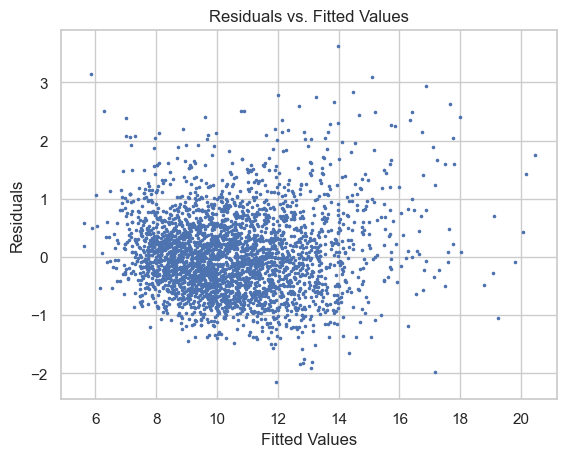

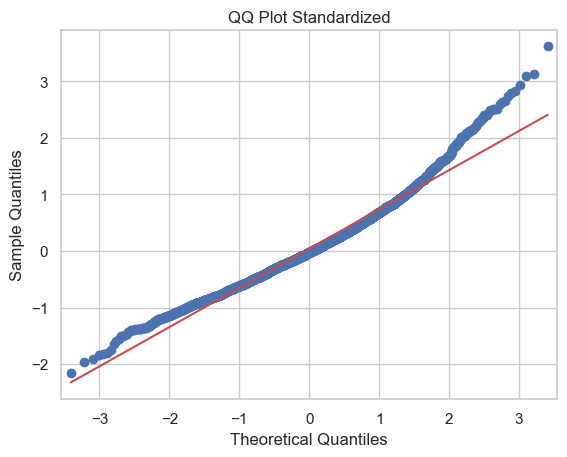

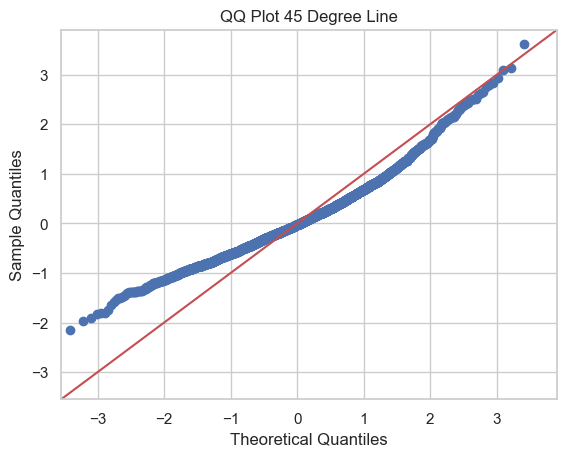

In [10]:
#Huber-White Robust Regression is robust to outliers and helps with heteroskedasticity

model = smf.rlm(formula=dv[0] + ' ~' + features, data=df, M=sm.robust.norms.HuberT())
results = model.fit()

print(results.summary2())

#Check assumptions of heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()



Cross-validated score: [-0.55615199 -0.5110981  -0.52799513 -0.57967721 -0.54498829 -0.53690631
 -0.56237242 -0.49186528 -0.53707913 -0.50750275]
Mean Absolute Error: 0.5484113580350652
Mean Squared Error: 0.5027284991199298
Root Mean Squared Error: 0.7090334964724373
R2: 0.8999436906483997
Adjusted R2: 0.8984376690589119
Intercept: [0.15741713]
Coefficients: [[ 0.         -0.02540365  0.1105225   0.05888474  0.07358429  0.12118833
   0.01953403  0.08156404 -0.02707442 -0.01454379 -0.03106238  0.11969334
   0.11965562  0.02362535 -0.02293031 -0.09824919]]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0', 'ruca', 'bb_int_struct'],
      dtype='object')


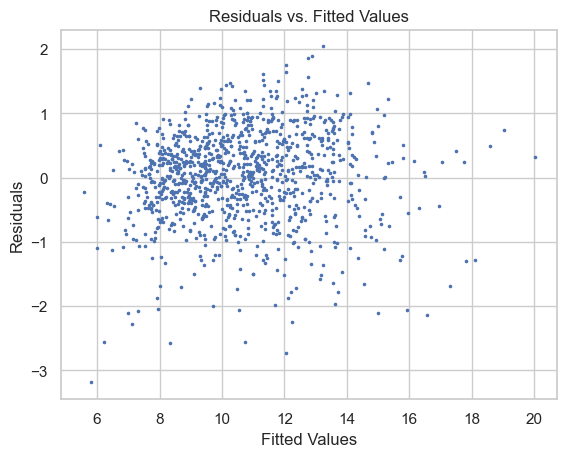

In [11]:
#Linear Regression using scikit-learn, train-test split, and cross-validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1234)


model = linear_model.LinearRegression()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

#adjusted R2
n = X_test.shape[0]
p = X_test.shape[1]
r2 = metrics.r2_score(y_test, y_pred)
adj_r2 = 1 - ((1-r2)*(n-1)/(n-p-1))
print('Adjusted R2:', adj_r2)

#coef and intercept with column names
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)

# Normality of residuals scatter plot
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

In [12]:
#Linear regression with Elastic Net regularization
#Elastic Net is a combination of L1 and L2 regularization which can help with multicollinearity and overfitting

model = linear_model.ElasticNet()
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)

y_pred = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))


print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)


Cross-validated score: [-0.61855738 -0.57046467 -0.55850825 -0.65012106 -0.62381746 -0.60133127
 -0.57910783 -0.51205331 -0.57401501 -0.56829856]
Mean Absolute Error: 0.6050899133088372
Mean Squared Error: 0.5989620365780497
Root Mean Squared Error: 0.7739263767168358
R2: 0.8807906634960412
Intercept: [1.11508677]
Coefficients: [ 0.         -0.01394946  0.11452468  0.04964483  0.          0.08682263
  0.          0.06384188 -0.         -0.         -0.02827376  0.
  0.15902227  0.01740098 -0.         -0.        ]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0', 'ruca', 'bb_int_struct'],
      dtype='object')


Cross-validated score: [-0.55629538 -0.51114285 -0.52787415 -0.5739167  -0.54481752 -0.53686395
 -0.56170897 -0.49141115 -0.53682147 -0.50755264]
Mean Absolute Error: 0.5485327456399081
Mean Squared Error: 0.5032551100310865
Root Mean Squared Error: 0.7094047575475417
R2: 0.899838881105422
Intercept: [0.09349928]
Coefficients: [[ 0.         -0.02544319  0.11055415  0.05873318  0.07365386  0.12124913
   0.019404    0.08145377 -0.02704794 -0.01461666 -0.03117524  0.11956333
   0.1195452   0.02397747 -0.02282064 -0.02126152]]
Features: Index(['Intercept', 'pct_dg_bb_int', 'brfss_access2_ageadjprv',
       'brfss_checkup_ageadjprv', 'brfss_mhlth_ageadjprv',
       'brfss_obesity_ageadjprv', 'pct_ed_lt9', 'pct_ed_9_12', 'pct_ed_hs',
       'pct_ed_asc', 'pct_age_gte65', 'pct_occ_unemp', 'pct_ses_pov',
       'pct_tp_veh_0', 'ruca', 'bb_int_struct'],
      dtype='object')


Text(0.5, 1.0, 'Residuals vs. Fitted Values')

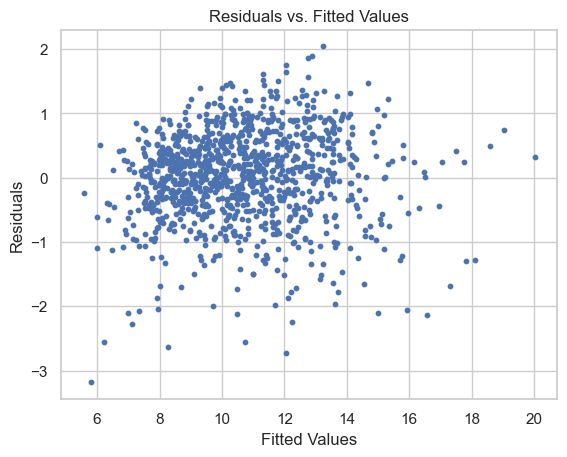

In [13]:
#Ridge Regression only model with L2 regularization

model = linear_model.Ridge(alpha=10)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
print("Cross-validated score:", scores)
y_pred = model.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:',  metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
#print coef and intercept with column names
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("Features:", X.columns)
#plot residuals
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, s=10)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
